In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers as fh, dfhelpers as dfh
from pathlib import Path

In [4]:
# base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')
base_location = Path(r'/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs')


load_folder = base_location / Path(r'Figure_1_2')
h5_beta_locations = str((load_folder / Path(r'by_mouse\interim-new_0-ft\coefs\*_best_coeffs.h5')).resolve())

# load_folder = base_location / Path(r'Figure_1_2')
# h5_beta_locations = str((load_folder / Path(r'all\f1*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_3')
# h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_4_g1')
# h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_4_g2')
# h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_5_g1')
# h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_5_g2')
# h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
load_folder = base_location / Path(r'Figure_5_g5')
h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

out_folder = base_location / Path(r'final_outputs_rev')

# h5_beta_locations = Path('/Users/josh/Dropbox (HMS)/jz/Tetanus/1194_1195_1214_1258_1259_2_best_coeffs.h5')
out_loc = str((out_folder).resolve())
h5_beta_locations = glob.glob(h5_beta_locations)

In [5]:
h5_lst = []
for h5_coef_fn in h5_beta_locations:
    h5f = pd.HDFStore(h5_coef_fn)
    h5fk = h5f.keys()
    for key in h5fk:
        h5_df = pd.read_hdf(h5f, key).reset_index()
        h5_df['fn'] = h5_coef_fn
        h5_df['key'] = key
        h5_df = h5_df.set_index(['fn','key'])
        
        
        h5_df = h5_df.sort_values('channel_name')
        h5_df['channel'] = h5_df['channel_name'].str.split('_').apply(lambda x: x[0])
        h5_df['run_num'] = h5_df['channel_name'].str.split('_').apply(lambda x: x[-1])
        
        h5_lst.append(h5_df)
concat = pd.concat(h5_lst, axis=0)

In [6]:
fh.create_folder_if_not_exists(out_loc)

In [7]:
base_keys = list({
                # 'gACH':(0,0),
                # 'rDA':(0,0),
                # 'gDA':(0,0),
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndex':(0,0),
                'photometrySideInIndex':(0,0),
                'photometrySideInIndexr':(0,0),
                'photometrySideOutIndex':(0,0),
                'sl': (0,0),
                'spnnrOff': (0,0),
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndex':(0,0),
                'photometrySideInIndexAA':(0,0),
                'photometrySideInIndexAa':(0,0),
                'photometrySideInIndexaA':(0,0),
                'photometrySideInIndexaa':(0,0),
                'photometrySideInIndexAB':(0,0),
                'photometrySideInIndexAb':(0,0),
                'photometrySideInIndexaB':(0,0),
                'photometrySideInIndexab':(0,0),
                'photometrySideOutIndex':(0,0),
                'sl': (0,0),
                'spnnrOff': (0,0),
                }.keys())
# base_keys

In [8]:
save_mse_scatter = concat.reset_index().set_index(['mouse_id', 'channel', 'name', 'run_num'])[['mse_tr', 'mse_cv', 'mse_te']]
save_mse_scatter.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-mse_sctr.csv').resolve()))

save_r2_scatter = concat.reset_index().set_index(['mouse_id', 'channel', 'name', 'run_num'])[['r2_tr', 'r2_cv', 'r2_te']]
save_r2_scatter.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-r2_sctr.csv').resolve()))

In [9]:
agg = concat.drop(['channel_name', 'timestamp', 'run_num'], axis=1).groupby(['channel', 'name']).agg([np.size, np.mean, np.std])
stk = agg[['mse_tr', 'mse_cv', 'mse_te']].rename({'mse_tr':'01_mse_tr', 'mse_cv':'02_mse_cv', 'mse_te':'03_mse_te'}, axis=1).swaplevel(axis=1).stack()

stk['lb'] = stk['mean'] - 1.96*stk['std']/np.sqrt(stk['size'])
stk['mn'] = stk['mean']
stk['ub'] = stk['mean'] + 1.96*stk['std']/np.sqrt(stk['size'])

plt_df = stk[['lb', 'mn', 'ub']].unstack().swaplevel(axis=1)

gACH = plt_df.loc['gACH'] if 'gACH' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]
rDA = plt_df.loc['rDA'] if 'rDA' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]
gDA = plt_df.loc['gDA'] if 'gDA' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]

save_ci = stk[['mean', 'size', 'std']].unstack().swaplevel(axis=1).sort_index(axis=1)
save_ci.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-mse_ci.csv').resolve()))

In [10]:
stk

mean  size       std        lb  \
channel name                                                                    
gACH    base_simple             01_mse_tr  0.778394    10  0.002264  0.776991   
                                02_mse_cv  0.778894    10  0.002626  0.777267   
                                03_mse_te  0.780427    10  0.002294  0.779006   
        base_simple_gDA_to_gACH 01_mse_tr  0.697049    10  0.001778  0.695947   
                                02_mse_cv  0.698657    10  0.002049  0.697387   
                                03_mse_te  0.698754    10  0.001803  0.697636   
        base_simple_rDA_to_gACH 01_mse_tr  0.684538    10  0.001480  0.683621   
                                02_mse_cv  0.685429    10  0.002285  0.684013   
                                03_mse_te  0.686104    10  0.001506  0.685171   
        base_words              01_mse_tr  0.774497    10  0.002189  0.773141   
                                02_mse_cv  0.774544    10  0.002648  0.772903   
                                03_mse_te  0.777335    10  0.002193  0.775975   
        base_words_gDA_to_gACH  01_mse_tr  0.687303    20  0.006640  0.684393   
                                02_mse_cv  0.688699    20  0.007282  0.685507   
                                03_mse_te  0.689680    20  0.006695  0.686745   
        gDA_to_gACH             01_mse_tr  0.897271    10  0.002017  0.896021   
                                02_mse_cv  0.897911    10  0.002204  0.896545   
                                03_mse_te  0.897786    10  0.002001  0.896546   
        rDA_to_gACH             01_mse_tr  0.872813    10  0.001235  0.872048   
                                02_mse_cv  0.872214    10  0.003066  0.870314   
                                03_mse_te  0.872914    10  0.001242  0.872144   
gDA     base_simple             01_mse_tr  0.955940    10  0.002323  0.954500   
                                02_mse_cv  0.956396    10  0.002698  0.954724   
                                03_mse_te  0.957678    10  0.002331  0.956233   
        base_simple_gACH_to_gDA 01_mse_tr  0.859724    10  0.002440  0.858211   
                                02_mse_cv  0.860834    10  0.004128  0.858276   
                                03_mse_te  0.862530    10  0.002482  0.860992   
        base_words              01_mse_tr  0.953419    10  0.002343  0.951967   
                                02_mse_cv  0.955286    10  0.003615  0.953045   
                                03_mse_te  0.955819    10  0.002332  0.954374   
        base_words_gACH_to_gDA  01_mse_tr  0.857740    10  0.002444  0.856225   
                                02_mse_cv  0.859625    10  0.003192  0.857646   
                                03_mse_te  0.861162    10  0.002473  0.859629   
        gACH_to_gDA             01_mse_tr  0.909743    10  0.002250  0.908348   
                                02_mse_cv  0.910116    10  0.002931  0.908299   
                                03_mse_te  0.910767    10  0.002274  0.909358   
rDA     base_simple             01_mse_tr  0.846373    10  0.002677  0.844713   
                                02_mse_cv  0.847576    10  0.002932  0.845759   
                                03_mse_te  0.847572    10  0.002670  0.845917   
        base_simple_gACH_to_rDA 01_mse_tr  0.764663    10  0.002551  0.763081   
                                02_mse_cv  0.765859    10  0.002966  0.764020   
                                03_mse_te  0.765651    10  0.002559  0.764065   
        base_words              01_mse_tr  0.840527    10  0.002707  0.838849   
                                02_mse_cv  0.842423    10  0.002737  0.840727   
                                03_mse_te  0.842378    10  0.002715  0.840695   
        base_words_gACH_to_rDA  01_mse_tr  0.759612    10  0.002574  0.758017   
                                02_mse_cv  0.761786    10  0.002873  0.760005   
                                03_mse_te  0.761276    10  0.002597  0.759667 

In [11]:
import matplotlib.pyplot as plt

['', '', '', '', '', '', '']


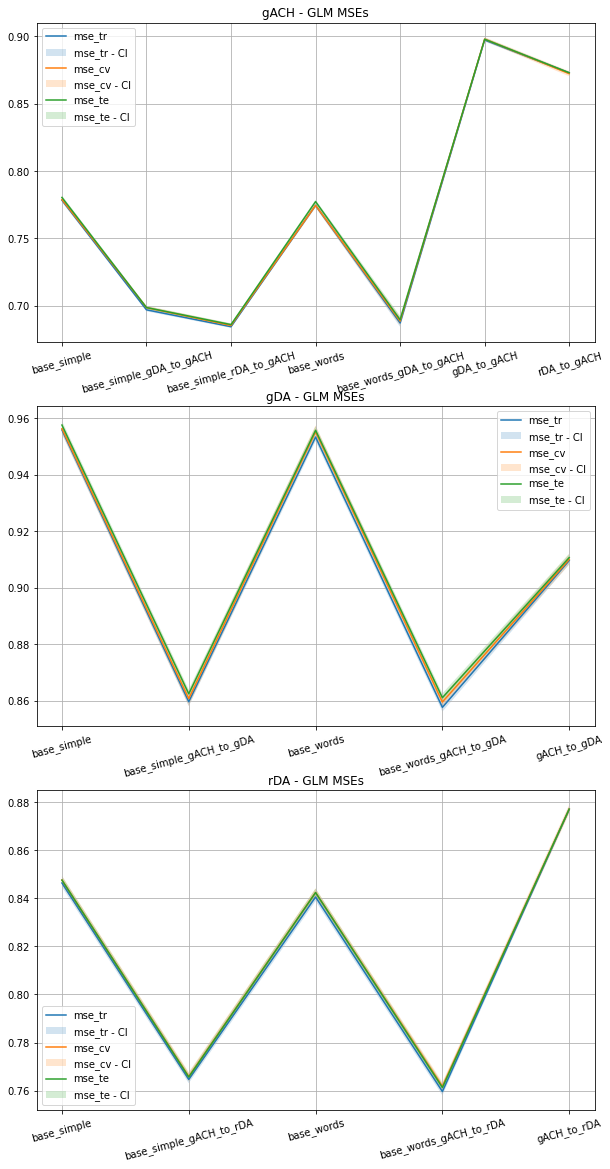

In [12]:
rot = 15

fig,axes=plt.subplots(3,1,figsize=(10,20))
fig.set_facecolor('w')

if len(gACH) > 0:
    ax = axes[0]
    ax.plot(gACH.index, gACH['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(gACH.index, gACH['01_mse_tr']['lb'], gACH['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(gACH.index, gACH['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(gACH.index, gACH['02_mse_cv']['lb'], gACH['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(gACH.index, gACH['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(gACH.index, gACH['03_mse_te']['lb'], gACH['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    print([_.get_text() for _ in ax.xaxis.get_ticklabels()])
    ax.set_title('gACH - GLM MSEs')
    ax.legend()
    ax.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

if len(gDA) > 0:
    ax = axes[1]
    ax.plot(gDA.index, gDA['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(gDA.index, gDA['01_mse_tr']['lb'], gDA['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(gDA.index, gDA['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(gDA.index, gDA['02_mse_cv']['lb'], gDA['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(gDA.index, gDA['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(gDA.index, gDA['03_mse_te']['lb'], gDA['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    ax.set_title('gDA - GLM MSEs')
    ax.legend()
    ax.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

if len(rDA) > 0:
    ax = axes[2]
    ax.plot(rDA.index, rDA['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(rDA.index, rDA['01_mse_tr']['lb'], rDA['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(rDA.index, rDA['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(rDA.index, rDA['02_mse_cv']['lb'], rDA['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(rDA.index, rDA['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(rDA.index, rDA['03_mse_te']['lb'], rDA['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    ax.set_title('rDA - GLM MSEs')
    ax.legend()
    ax.grid(True)

    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

plt.show()
